In [1]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from itertools import combinations

In [2]:
# SET UP RANDOM INITIAL CONDITIONS
rng = np.random.default_rng(seed=101)

N = 5
DIM = 2
X_LOWER,X_UPPER = -1, 1
V_LOWER,V_UPPER = -0.1, 0.1
# create random x and y coordinates for each particle, between 0 and 1
r = rng.uniform(X_LOWER, X_UPPER, (DIM,N))
# r = np.array([[0,0],[0.5,1],[1,0.3]]).T
v = rng.uniform(V_LOWER, V_UPPER, (DIM,N))
print(r)
# plt.scatter(*r)

[[ 0.88706501 -0.28115793  0.56961082  0.18255637 -0.41134288]
 [ 0.84545137  0.73866309 -0.27172315  0.94635363 -0.55095134]]


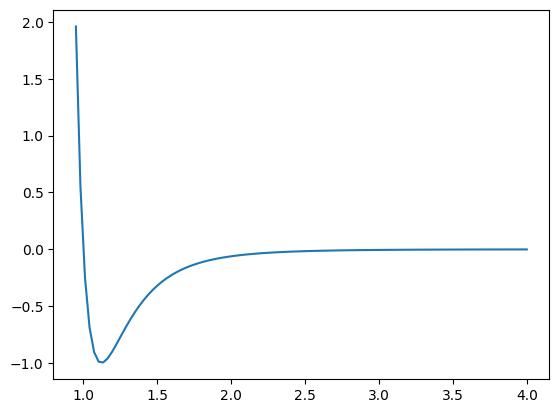

In [7]:
class Symbolic():
    epsilon = sp.Symbol("epsilon")
    sigma = sp.Symbol("sigma")
    r = sp.Symbol("r")
    lennard_jones_potential = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)
    force = -sp.diff(lennard_jones_potential,r)

EPSILON = 1
SIGMA = 1

lj_potential = sp.lambdify(Symbolic.r,Symbolic.lennard_jones_potential.subs({Symbolic.epsilon:EPSILON, Symbolic.sigma:SIGMA}))
lj_force = sp.lambdify(Symbolic.r,Symbolic.force.subs({Symbolic.epsilon:EPSILON, Symbolic.sigma:SIGMA}))


x = np.linspace(0.95,4,100)
plt.plot(x,lj_potential(x))


C:\Users\juliu\AppData\Local\Temp\ipykernel_14240\3809814100.py:14: RuntimeWarning: invalid value encountered in divide
  unit_displacements = pair_displacements(r) / pair_distances(r)


(-1.0, 2.0)

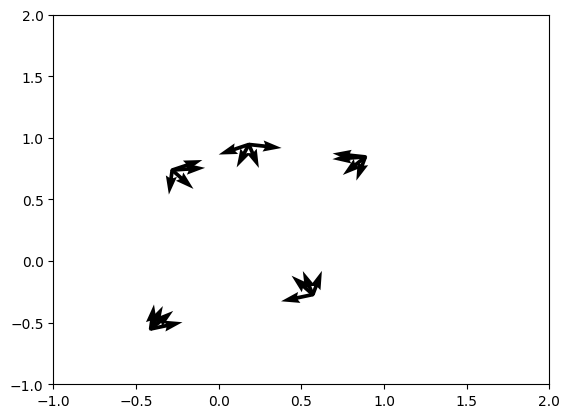

In [4]:
x = r[0]
def pair_displacements_1D(x):
    return -np.diff(np.meshgrid(x,x),axis=0)[0]
    # return np.diff(np.asarray(combinations(x,2)),axis=1).ravel()

def pair_displacements(r):
    return np.array([pair_displacements_1D(x) for x in r])

def pair_distances(r):
    return np.sqrt(np.sum(pair_displacements(r)**2,axis=0))

displacements = pair_displacements(r)
distances = pair_distances(r)
unit_displacements = pair_displacements(r) / pair_distances(r)
unit_displacements[np.isnan(unit_displacements)] = 0

# plt.quiver(np.repeat(r[0],N),np.repeat(r[1],N), displacements[0,:,:].ravel(),displacements[1,:,:].ravel(), angles="xy", scale=1, scale_units="xy")
def plot_each_arrow(r,A):
    return plt.quiver(
        *[np.repeat(x,N)for x in r],
        *[A[i,:,:].ravel() for i in range(DIM)],
        angles="xy", scale=1, scale_units="xy")
plot_each_arrow(r,unit_displacements*0.2)

plt.xlim(-1,2)
plt.ylim(-1,2)


In [5]:
def F_bounds(r):
    return (r<X_LOWER)*(r-X_LOWER)**2 + (r>X_UPPER)*(r-X_UPPER)**2

def calc_a(r):
    m = 1
    F_grav = np.array(0,-0.5)
    F = F_bounds(r)
    a = F/m

def step(r,v,a,dt):
    r = r + v*dt
    v = v + a*dt
    return r,v

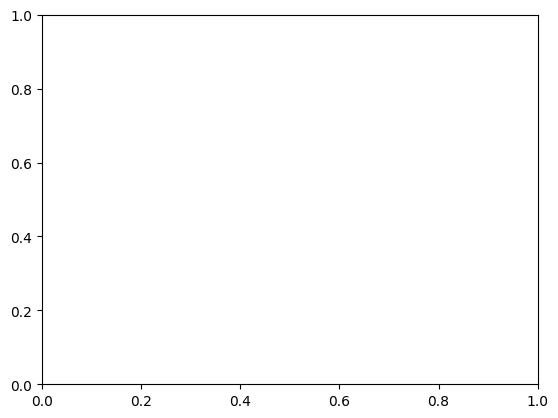

In [6]:
fig, ax = plt.subplots(1,1)